In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

### Load the data

In [2]:
csvs = os.listdir('data/accepted/')

In [3]:
# make sure all csv files have the same headers
with open("data/accepted/"+csvs[0], 'r') as f:
    columns = f.readlines()[0]
for c in csvs[1:]:
    with open("data/accepted/" + c, 'r') as f:
        if f.readlines()[0] != columns:
            print(c)

In [2]:
dtype = {'id':str,'member_id':str,'loan_amnt':float,'funded_amnt':float,'funded_amnt_inv':float,
         'term':str,'int_rate':str,
         'installment':float,'grade':str,'sub_grade':str,'emp_title':str,'emp_length':str,'home_ownership':str,
         'annual_inc':float,'verification_status':str,'issue_d':str,'loan_status':str,'pymnt_plan':str,'url':str,
         'desc':str,'purpose':str,'title':str,'zip_code':str,'addr_state':str,'dti':float,'delinq_2yrs':float,
         'earliest_cr_line':str,'inq_last_6mths':float,'mths_since_last_delinq':float,
         'mths_since_last_record':float,
         'open_acc':float,'pub_rec':float,'revol_bal':float,'total_acc':float,'initial_list_status':str,
         'out_prncp':float,
         'out_prncp_inv':float,'total_pymnt':float,'total_pymnt_inv':float,'total_rec_prncp':float,
         'total_rec_int':float,
         'total_rec_late_fee':float,'recoveries':float,'collection_recovery_fee':float,'last_pymnt_d':str,
         'last_pymnt_amnt':float,'next_pymnt_d':str,'last_credit_pull_d':str,'collections_12_mths_ex_med':float,
         'mths_since_last_major_derog':float,'policy_code':str,'application_type':str,'annual_inc_joint':float,
         'dti_joint':float,'verification_status_joint':str,'acc_now_delinq':float,'tot_coll_amt':float,
         'tot_cur_bal':float,
         'open_acc_6m':float,'open_act_il':float,'open_il_12m':float,'open_il_24m':float,
         'mths_since_rcnt_il':float,'total_bal_il':float,
         'il_util':str,'open_rv_12m':float,'open_rv_24m':float,'max_bal_bc':float,'all_util':float,
         'total_rev_hi_lim':float,
         'inq_fi':float,'total_cu_tl':float,'inq_last_12m':float,'acc_open_past_24mths':float,'avg_cur_bal':float,
         'bc_open_to_buy':str,'bc_util':str,'chargeoff_within_12_mths':float,'delinq_amnt':float,
         'mo_sin_old_il_acct':str,
         'mo_sin_old_rev_tl_op':str,'mo_sin_rcnt_rev_tl_op':str,'mo_sin_rcnt_tl':str,'mort_acc':float,
         'mths_since_recent_bc':float,'mths_since_recent_bc_dlq':float,'mths_since_recent_inq':float,
         'mths_since_recent_revol_delinq':float,
         'num_accts_ever_120_pd':float,'num_actv_bc_tl':float,'num_actv_rev_tl':float,'num_bc_sats':float,
         'num_bc_tl':float,
         'num_il_tl':float,'num_op_rev_tl':float,'num_rev_accts':float,'num_rev_tl_bal_gt_0':float,'num_sats':float,
         'num_tl_120dpd_2m':float,'num_tl_30dpd':float,'num_tl_90g_dpd_24m':float,'num_tl_op_past_12m':float,
         'pct_tl_nvr_dlq':float,'percent_bc_gt_75':float,'pub_rec_bankruptcies':float,'tax_liens':float,
         'tot_hi_cred_lim':float,
         'total_bal_ex_mort':float,'total_bc_limit':float,'total_il_high_credit_limit':float,'revol_bal_joint':float,
         'sec_app_earliest_cr_line':str,'sec_app_inq_last_6mths':float,'sec_app_mort_acc':str,'sec_app_open_acc':str,
         'sec_app_revol_util':str,'sec_app_open_act_il':str,'sec_app_num_rev_accts':float,
         'sec_app_chargeoff_within_12_mths':float,
         'sec_app_collections_12_mths_ex_med':float,'sec_app_mths_since_last_major_derog':float,'hardship_flag':str,
         'hardship_type':str,'hardship_reason':str,'hardship_status':str,'deferral_term':str,'hardship_amount':float,
         'hardship_start_date':str,'hardship_end_date':str,'payment_plan_start_date':str,'hardship_length':str,
         'hardship_dpd':float,'hardship_loan_status':str,'orig_projected_additional_accrued_interest':float,
         'hardship_payoff_balance_amount':float,'hardship_last_payment_amount':float,'disbursement_method':str,
         'debt_settlement_flag':str,'debt_settlement_flag_date':str,'settlement_status':str,'settlement_date':str,
         'settlement_amount':float,'settlement_percentage':float,'settlement_term':str}

In [5]:
df = pd.DataFrame(columns=dtype.keys())
for i,c in enumerate(csvs):
    df = df.append(pd.read_csv("data/accepted/" + c, dtype=dtype))

In [6]:
print("number of data points: {}".format(len(df)))

number of data points: 1646801


### Drop current and unlabeled borrowers

In [7]:
print(df.loan_status.unique())

['Fully Paid' 'Charged Off' nan
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off' 'Current'
 'Late (31-120 days)' 'In Grace Period' 'Late (16-30 days)' 'Default']


In [8]:
len(df[df.loan_status=='Current'].index)

810381

In [9]:
len(df[df.loan_status!='Current'].index)

836420

In [10]:
# drop current borrowers
df = df[df.loan_status!='Current']
len(df)

836420

In [11]:
print(df.loan_status.unique())

['Fully Paid' 'Charged Off' nan
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off'
 'Late (31-120 days)' 'In Grace Period' 'Late (16-30 days)' 'Default']


We drop current borrowers, as we are primarily interested in those who have already paid off or charged off on their loans. We save the current borrowers to predict how they will behave for future projects. Note that "Charged Off" means no further payment is expected. This typically occurs when a payment is 150+ days past due. "Default" typically means the borrower has not made a payment for 121+ days, but the account has not been closed or sent to collections yet (see https://help.lendingclub.com/hc/en-us/articles/216127747-What-is-the-difference-between-a-loan-that-is-in-default-and-a-loan-that-has-been-charged-off-)

In [12]:
current_df = df[(df.loan_status != 'Fully Paid') & (df.loan_status != 'Charged Off') 
                & (df.loan_status != 'Does not meet the credit policy. Status:Fully Paid')
                & (df.loan_status != 'Does not meet the credit policy. Status:Charged Off')]

In [13]:
current_df.to_csv("data/current_borrowers.csv", index=False)

In [14]:
# drop current borrowers
df = df[df.loan_status!='In Grace Period']
df = df[df.loan_status!='Late (31-120 days)']
df = df[df.loan_status!='Late (16-30 days)']
df = df[df.loan_status!='Default']
len(df)

790682

We drop the unlabeled data points, as the proportion of unlabeled points (about .003%) is marginal.

In [15]:
print("number of unlabeled points: {}".format(len(df) - df.loan_status.value_counts().sum()))

number of unlabeled points: 23


In [16]:
# drop unlabeled data points (nan)
df = df.dropna(subset=['loan_status'])
len(df)

790659

In [17]:
print(df.loan_status.unique())

['Fully Paid' 'Charged Off'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off']


In [18]:
df.loan_status.value_counts()

Fully Paid                                             627124
Charged Off                                            160786
Does not meet the credit policy. Status:Fully Paid       1988
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

Observations labeled with "Does not meet the credit policy" are people that borrowed from Lending Club in the past, but would not currently qualify for a loan under Lending Club's current policy. We save them as a separate dataframe for further analysis; perhaps we can identify the change in Lending Club's policy that would cause those borrowers to not qualify for a loan today.

In [19]:
unqualified_df = df[df.loan_status.str.contains("Does not meet the credit policy")]
len(unqualified_df)

2749

In [20]:
unqualified_df.to_csv("data/unqualified_df.csv", index=False)
df = df[(df.loan_status != 'Does not meet the credit policy. Status:Fully Paid') & 
        (df.loan_status != 'Does not meet the credit policy. Status:Charged Off')]

In [21]:
len(df)

787910

### Label the data

In [22]:
df.loan_status = df.loan_status.map({'Fully Paid':1, 'Charged Off':0})

In [24]:
df.loan_status.value_counts()

1    627124
0    160786
Name: loan_status, dtype: int64

In [25]:
df.to_csv('data/labeled.csv', index=False)

### Get rid of unique/uniform columns

In [3]:
dtype['loan_status'] = int
df = pd.read_csv('data/labeled.csv', dtype=dtype)
len(df.columns)

145

In [4]:
# find features with uniform values
rows = len(df)
for col in df.columns:
    if len(df[col].unique()) == 1:
        print(col, len(df[col].unique()))
        df.drop(col, axis=1, inplace=True)

hardship_flag 1
id 1
member_id 1
next_pymnt_d 1
out_prncp 1
out_prncp_inv 1
policy_code 1
pymnt_plan 1
url 1


In [5]:
print(df.shape)

136
(787910, 136)


Now we check for null values. For columns with a large amount of missing values (70% or more), we drop them.

In [43]:
null_counts = dict(df.isnull().sum())
null_cols = []
for key,val in null_counts.items():
    if val != 0:
        print(key, '\t', val/df.shape[0])
    if val/df.shape[0] >= 0.7:
        null_cols.append(key)

acc_open_past_24mths 	 0.060008122755137006
all_util 	 0.7942696500869388
annual_inc_joint 	 0.9958002817580688
avg_cur_bal 	 0.08571918112474775
bc_open_to_buy 	 0.06964754857788326
bc_util 	 0.07024025586678681
debt_settlement_flag_date 	 0.9854691525681867
deferral_term 	 0.9994567907502125
desc 	 0.8483748143823533
dti 	 3.6806234214567655e-05
dti_joint 	 0.9958002817580688
hardship_amount 	 0.9994567907502125
hardship_dpd 	 0.9994567907502125
hardship_end_date 	 0.9994567907502125
hardship_last_payment_amount 	 0.9994567907502125
hardship_length 	 0.9994567907502125
hardship_loan_status 	 0.9994567907502125
hardship_payoff_balance_amount 	 0.9994567907502125
hardship_reason 	 0.9994567907502125
hardship_start_date 	 0.9994567907502125
hardship_status 	 0.9994567907502125
hardship_type 	 0.9994567907502125
il_util 	 0.8200835120762524
inq_fi 	 0.7942569582820372
inq_last_12m 	 0.7942582274625275
inq_last_6mths 	 1.2691804901575054e-06
last_credit_pull_d 	 4.82288586259852e-05
last_

In [6]:
print(len(null_cols))

52


In [44]:
df.drop(null_cols, axis=1, inplace=True)
len(df.columns)

66

In [9]:
for col in df.columns:
    if df[col].dtype == 'O':
        print(col)

addr_state
application_type
bc_open_to_buy
bc_util
debt_settlement_flag
disbursement_method
earliest_cr_line
emp_length
emp_title
grade
home_ownership
initial_list_status
int_rate
issue_d
last_credit_pull_d
last_pymnt_d
mo_sin_old_il_acct
mo_sin_old_rev_tl_op
mo_sin_rcnt_rev_tl_op
mo_sin_rcnt_tl
purpose
revol_util
sub_grade
term
title
verification_status
zip_code


In [5]:
df['zip_code'].head()

0    860xx
1    309xx
2    606xx
3    917xx
4    972xx
Name: zip_code, dtype: object

In [6]:
# drop the zip_code feature, since we can't work with 3-digit zip codes, and addr_state gives the state
df.drop("zip_code", axis=1, inplace=True)

In [7]:
df['term'].head(15)

0      36 months
1      60 months
2      36 months
3      36 months
4      60 months
5      36 months
6      60 months
7      36 months
8      60 months
9      60 months
10     60 months
11     36 months
12     36 months
13     36 months
14     36 months
Name: term, dtype: object

In [7]:
df.term = df.term.apply(lambda x: int(x.split()[0]))
df['term'].head()

0    36
1    60
2    36
3    36
4    60
Name: term, dtype: int64

In [30]:
df['title'].head(15)

0                                  Computer
1                                      bike
2                      real estate business
3                                  personel
4                                  Personal
5     My wedding loan I promise to pay back
6                                      Loan
7                           Car Downpayment
8      Expand Business & Buy Debt Portfolio
9               Building my credit history.
10               High intrest Consolidation
11                            Consolidation
12                                  freedom
13                            citicard fund
14                               Other Loan
Name: title, dtype: object

In [34]:
# make lower case
df['title'] = df['title'].str.lower()

In [35]:
# got rid of about 10000 categories
len(df['title'].unique())

50798

In [36]:
df['title'].isnull().sum()

7387

In [37]:
# keep top x categories
# use substring matching to combine categories (other ways to combine categories)
# make new categories for leftovers
df['title'].value_counts(normalize=True).iloc[:30]

debt consolidation           0.482619
credit card refinancing      0.163980
home improvement             0.051159
other                        0.040810
major purchase               0.015467
consolidation                0.009376
medical expenses             0.008539
business                     0.008346
car financing                0.006965
debt consolidation loan      0.005800
vacation                     0.005336
moving and relocation        0.005216
credit card consolidation    0.004302
personal loan                0.004033
home buying                  0.003472
consolidation loan           0.003152
credit card payoff           0.003083
credit card refinance        0.002990
consolidate                  0.002528
personal                     0.002470
loan                         0.001914
payoff                       0.001722
credit cards                 0.001681
freedom                      0.001555
debt                         0.001489
my loan                      0.001461
debt consoli

In [12]:
df['revol_util'].head()

0    83.7%
1     9.4%
2    98.5%
3      21%
4    53.9%
Name: revol_util, dtype: object

In [8]:
df.revol_util = df.revol_util.str[:-1].astype('float')/100
df.revol_util.head()

0    0.837
1    0.094
2    0.985
3    0.210
4    0.539
Name: revol_util, dtype: float64

In [28]:
df['purpose'].value_counts(normalize=True) # consider using purpose and dropping title, since title is user input, purpose is set categorical

debt_consolidation    0.590989
credit_card           0.214731
home_improvement      0.062277
other                 0.053793
major_purchase        0.021473
small_business        0.012644
car                   0.011010
medical               0.010686
moving                0.007026
vacation              0.006258
house                 0.005073
wedding               0.002882
renewable_energy      0.000742
educational           0.000414
Name: purpose, dtype: float64

In [9]:
# drop title (for now), as purpose is a more uniform, consistent way to measure a similar thing (high correlation)
df.drop('title', axis=1, inplace=True)

In [16]:
df.emp_title.head()

0                         NaN
1                       Ryder
2                         NaN
3         AIR RESOURCES BOARD
4    University Medical Group
Name: emp_title, dtype: object

In [36]:
len(df.emp_title.unique())

274750

In [10]:
# for similar reasoning, drop emp_title (user input, very messy)
df.drop('emp_title', axis=1, inplace=True)

In [12]:
len(df.columns)

83

In [17]:
df['mo_sin_rcnt_tl'].head(15)

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
10    NaN
11    NaN
12    NaN
13    NaN
14    NaN
Name: mo_sin_rcnt_tl, dtype: object

In [18]:
df['mo_sin_rcnt_tl'].isnull().sum()/df.shape[0]

0.08570395095886586

In [19]:
df['mo_sin_rcnt_rev_tl_op'].isnull().sum()/df.shape[0]

0.08570522013935601

In [20]:
df['mo_sin_old_rev_tl_op'].isnull().sum()/df.shape[0]

0.08570522013935601

In [21]:
df['mo_sin_old_il_acct'].isnull().sum()/df.shape[0]

0.11267403637471285

In [22]:
df['last_pymnt_d'].head()

0    Jan-2015
1    Apr-2013
2    Jun-2014
3    Jan-2015
4    Jan-2017
Name: last_pymnt_d, dtype: object

In [11]:
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'])
df['last_pymnt_d'].head()

0   2015-01-01
1   2013-04-01
2   2014-06-01
3   2015-01-01
4   2017-01-01
Name: last_pymnt_d, dtype: datetime64[ns]

In [12]:
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'])
df['last_credit_pull_d'].head()

0   2017-11-01
1   2016-10-01
2   2017-06-01
3   2016-04-01
4   2017-01-01
Name: last_credit_pull_d, dtype: datetime64[ns]

In [13]:
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['issue_d'].head()

0   2011-12-01
1   2011-12-01
2   2011-12-01
3   2011-12-01
4   2011-12-01
Name: issue_d, dtype: datetime64[ns]

In [29]:
df['int_rate'].head()

0     10.65%
1     15.27%
2     15.96%
3     13.49%
4     12.69%
Name: int_rate, dtype: object

In [14]:
df.int_rate = df.int_rate.str[:-1].astype('float')/100
df.int_rate.head()

0    0.1065
1    0.1527
2    0.1596
3    0.1349
4    0.1269
Name: int_rate, dtype: float64

In [15]:
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])
df['earliest_cr_line'].head()

0   1985-01-01
1   1999-04-01
2   2001-11-01
3   1996-02-01
4   1996-01-01
Name: earliest_cr_line, dtype: datetime64[ns]

In [16]:
df.bc_util = df.bc_util.astype('float')

In [19]:
df.bc_util.tail(15)

787895      0.3
787896    100.1
787897      9.8
787898     24.5
787899     64.7
787900     12.8
787901     51.7
787902     83.5
787903     20.0
787904     54.2
787905     60.5
787906     68.0
787907     61.7
787908     95.8
787909     48.0
Name: bc_util, dtype: float64

In [20]:
df.bc_util.isnull().sum() # I suspect that these are missing for a particular csv subset of the data, same for below

55343

In [17]:
df.bc_open_to_buy = df.bc_open_to_buy.astype('float')

In [23]:
df.bc_open_to_buy.isnull().sum()

54876

In [24]:
df.bc_open_to_buy.tail(15)

787895    40278.0
787896        0.0
787897    52566.0
787898    53687.0
787899     8710.0
787900    74790.0
787901     2416.0
787902     3582.0
787903    28475.0
787904    12830.0
787905     4625.0
787906    10386.0
787907    18465.0
787908      921.0
787909    13771.0
Name: bc_open_to_buy, dtype: float64

In [21]:
# distribution of labels
df.loan_status.value_counts(normalize=True)

1    0.795934
0    0.204066
Name: loan_status, dtype: float64

In [25]:
df.shape

(787910, 81)

In [18]:
# drop sub_grade, as that information can be captured in grade
df.drop('sub_grade', axis=1, inplace=True)

In [27]:
df.acc_now_delinq.value_counts(normalize=True)

0.0    0.995480
1.0    0.004264
2.0    0.000216
3.0    0.000027
4.0    0.000009
5.0    0.000003
6.0    0.000001
Name: acc_now_delinq, dtype: float64

In [28]:
df[df.acc_now_delinq != 0]['loan_status'].value_counts(normalize=True)

1    0.752878
0    0.247122
Name: loan_status, dtype: float64

In [19]:
# drop acc_now_delinq since 99.5% of applicants have 0 delinquent accounts
# of the .5% left, 75% are labeled as paid off, similar to the overall distribution... so we drop
df.drop('acc_now_delinq', axis=1, inplace=True)

In [30]:
df[df.isnull().any(axis=1)].shape

(572059, 79)

In [49]:
df.application_type.value_counts(normalize=True)

Individual    0.9958
Joint App     0.0042
Name: application_type, dtype: float64

In [51]:
df[df.application_type != 'Individual']['loan_status'].value_counts(normalize=True)

1    0.81777
0    0.18223
Name: loan_status, dtype: float64

In [20]:
# for similar reasoning, we drop application_type
df.drop("application_type", axis=1, inplace=True)

In [57]:
df.chargeoff_within_12_mths.value_counts(normalize=True)

0.0     0.992377
1.0     0.006892
2.0     0.000597
3.0     0.000090
4.0     0.000025
5.0     0.000009
7.0     0.000004
6.0     0.000004
8.0     0.000001
10.0    0.000001
Name: chargeoff_within_12_mths, dtype: float64

In [58]:
df[df.chargeoff_within_12_mths != 0]['loan_status'].value_counts(normalize=True)

1    0.777631
0    0.222369
Name: loan_status, dtype: float64

In [21]:
# for similar reasoning, we drop chargeoff_within_12_mths
df.drop("chargeoff_within_12_mths", axis=1, inplace=True)

In [62]:
df.collections_12_mths_ex_med.value_counts(normalize=True)

0.0     0.986973
1.0     0.012115
2.0     0.000781
3.0     0.000083
4.0     0.000027
6.0     0.000008
5.0     0.000006
12.0    0.000003
7.0     0.000001
16.0    0.000001
20.0    0.000001
10.0    0.000001
Name: collections_12_mths_ex_med, dtype: float64

In [63]:
df[df.collections_12_mths_ex_med != 0]['loan_status'].value_counts(normalize=True)

1    0.727978
0    0.272022
Name: loan_status, dtype: float64

In [22]:
# for similar reasoning, we drop chargeoff_within_12_mths
df.drop("collections_12_mths_ex_med", axis=1, inplace=True)

In [66]:
df.debt_settlement_flag.value_counts(normalize=True)

N    0.985469
Y    0.014531
Name: debt_settlement_flag, dtype: float64

In [23]:
# for similar reasoning, we drop chargeoff_within_12_mths
df.drop("debt_settlement_flag", axis=1, inplace=True)

In [24]:
# for similar reasoning, we drop chargeoff_within_12_mths
df.drop("delinq_amnt", axis=1, inplace=True)

In [25]:
# for similar reasoning, we drop chargeoff_within_12_mths
df.drop("disbursement_method", axis=1, inplace=True)

In [100]:
# MAYBE only keep the first 6 categories of this feature? due to dist.
df.mort_acc.value_counts(normalize=True)

0.0     0.392169
1.0     0.171371
2.0     0.142958
3.0     0.107744
4.0     0.076617
5.0     0.048553
6.0     0.028615
7.0     0.015241
8.0     0.007789
9.0     0.004032
10.0    0.002100
11.0    0.001129
12.0    0.000621
13.0    0.000343
14.0    0.000248
15.0    0.000126
16.0    0.000086
17.0    0.000049
18.0    0.000047
19.0    0.000031
20.0    0.000028
24.0    0.000018
21.0    0.000015
22.0    0.000015
23.0    0.000009
25.0    0.000009
27.0    0.000008
26.0    0.000007
29.0    0.000004
34.0    0.000004
31.0    0.000003
32.0    0.000003
30.0    0.000003
51.0    0.000001
47.0    0.000001
28.0    0.000001
37.0    0.000001
Name: mort_acc, dtype: float64

In [26]:
# for similar reasoning, we drop chargeoff_within_12_mths
df.drop("num_tl_120dpd_2m", inplace=True, axis=1)

In [27]:
# for similar reasoning, we drop chargeoff_within_12_mths
df.drop("num_tl_30dpd", inplace=True, axis=1)

In [28]:
# for similar reasoning, we drop chargeoff_within_12_mths
df.drop("num_tl_90g_dpd_24m", inplace=True, axis=1)

In [29]:
# for similar reasoning, we drop chargeoff_within_12_mths
df.drop("tax_liens", inplace=True, axis=1)

In [147]:
df.verification_status.value_counts(normalize=True)

Source Verified    0.359235
Verified           0.332176
Not Verified       0.308589
Name: verification_status, dtype: float64

In [30]:
df.columns

Index(['acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc',
       'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'collection_recovery_fee', 'debt_settlement_flag_date',
       ...
       'total_cu_tl', 'total_il_high_credit_limit', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee',
       'total_rec_prncp', 'total_rev_hi_lim', 'verification_status',
       'verification_status_joint'],
      dtype='object', length=121)

In [42]:
df[df.isnull().any(axis=1)].shape

(564595, 69)

In [44]:
# find column with most missing values
df.count().idxmin()

'mths_since_recent_revol_delinq'

In [45]:
df.mths_since_recent_revol_delinq.dtype

dtype('float64')

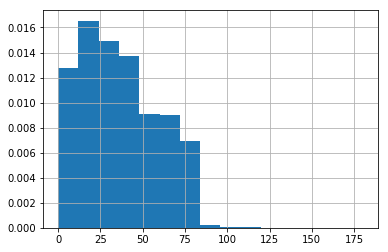

In [51]:
df.mths_since_recent_revol_delinq.hist(bins=15, normed=True)
plt.show()

In [52]:
df.mths_since_recent_revol_delinq.describe()

count    255930.000000
mean         36.214707
std          22.448495
min           0.000000
25%          17.000000
50%          33.000000
75%          53.000000
max         180.000000
Name: mths_since_recent_revol_delinq, dtype: float64

In [55]:
df.mths_since_recent_revol_delinq.isnull().sum()/df.shape[0]

0.6751786371539896

In [60]:
df[~df.mths_since_recent_revol_delinq.isnull()].loan_status.value_counts(normalize=True)

1    0.787708
0    0.212292
Name: loan_status, dtype: float64

In [61]:
df[df.mths_since_recent_revol_delinq.isnull()].loan_status.value_counts(normalize=True)

1    0.799891
0    0.200109
Name: loan_status, dtype: float64

In [31]:
# since most of mths_since_recent_revol_delinq is missing, and label dist reflects overall label distribution, we drop
# also, seems correlated with mths_since_last_delinq
df.drop("mths_since_recent_revol_delinq", axis=1, inplace=True)

In [63]:
df[df.isnull().any(axis=1)].shape

(465282, 68)

In [65]:
# find column with most missing values
col = df.count().idxmin()
print(col)
df[col].isnull().sum()/df.shape[0]

mths_since_last_delinq


0.5129748321508801

In [66]:
df[~df.mths_since_last_delinq.isnull()].loan_status.value_counts(normalize=True)

1    0.789061
0    0.210939
Name: loan_status, dtype: float64

In [67]:
df[df.mths_since_last_delinq.isnull()].loan_status.value_counts(normalize=True)

1    0.802458
0    0.197542
Name: loan_status, dtype: float64

In [32]:
# since most of mths_since_last_delinq is missing, and label distribution reflects overall label distribution, we drop
df.drop("mths_since_last_delinq", axis=1, inplace=True)

In [47]:
df[df.isnull().any(axis=1)].shape

(158317, 66)

In [45]:
# find column with most missing values
col = df.count().idxmin()
print(col)
print(df[col].isnull().sum())
df[col].isnull().sum()/df.shape[0]

mths_since_recent_inq
115154


0.14615121016359736

In [41]:
df.drop("orig_projected_additional_accrued_interest", axis=1, inplace=True)

In [33]:
df.columns

Index(['acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc',
       'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'collection_recovery_fee', 'debt_settlement_flag_date',
       ...
       'total_cu_tl', 'total_il_high_credit_limit', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee',
       'total_rec_prncp', 'total_rev_hi_lim', 'verification_status',
       'verification_status_joint'],
      dtype='object', length=119)

In [37]:
df[(np.abs(df['total_pymnt']) <= 1.1*np.abs(df['total_pymnt_inv'])) & (np.abs(df['total_pymnt']) >= .9*np.abs(df['total_pymnt_inv'])) ].shape[0]

783987

In [46]:
df.shape

(787910, 66)

In [34]:
df['total_pymnt'] = df['total_pymnt'].round(2)

In [35]:
df[['total_pymnt','total_pymnt_inv']]

,total_pymnt,total_pymnt_inv
0,5863.16,5833.84
1,1014.53,1014.53
2,3005.67,3005.67
3,12231.89,12231.89
4,4066.91,4066.91
5,5632.21,5632.21
6,10137.84,10137.84
7,3939.14,3939.14
8,647.50,647.50
9,1484.59,1477.70


In [39]:
# drop total_pymnt_inv because of high correlation with total_pymnt
df.drop("total_pymnt_inv", axis=1, inplace=True)

In [ ]:
# pub_rec
# pub_rec_bankruptcies
# recoveries
# total_coll_amt

In [48]:
df.columns

Index(['acc_open_past_24mths', 'addr_state', 'annual_inc', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'collection_recovery_fee', 'delinq_2yrs',
       'dti', 'earliest_cr_line', 'emp_length', 'funded_amnt',
       'funded_amnt_inv', 'grade', 'home_ownership', 'initial_list_status',
       'inq_last_6mths', 'installment', 'int_rate', 'issue_d',
       'last_credit_pull_d', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt',
       'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_op_past_12m', 'open_acc', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
       'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'recoveries', 'revol_bal',
       'revol_util', 'term', 't

In [49]:
months_cols = ['mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
               'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
               'mths_since_recent_bc', 'mths_since_recent_inq',]
df[months_cols].isnull().sum()/df.shape[0]

mo_sin_old_il_acct       0.112674
mo_sin_old_rev_tl_op     0.085705
mo_sin_rcnt_rev_tl_op    0.085705
mo_sin_rcnt_tl           0.085704
mths_since_recent_bc     0.068910
mths_since_recent_inq    0.146151
dtype: float64

In [51]:
df['mo_sin_old_il_acct'].value_counts(normalize=True)

494

In [52]:
# drop months columns because they are so specific, don't seem to matter as much
df.drop(months_cols, axis=1, inplace=True)

In [53]:
df[df.isnull().any(axis=1)].shape

(77053, 60)

In [55]:
# find column with most missing values
col = df.count().idxmin()
print(col)
print(df[col].isnull().sum())
print(df[col].isnull().sum()/df.shape[0])

pct_tl_nvr_dlq
67662
0.08587529032503713


In [56]:
df['pct_tl_nvr_dlq'].value_counts(normalize=True)

100.0    0.495925
95.0     0.017208
96.0     0.016274
90.0     0.014924
97.0     0.010816
92.0     0.010070
91.7     0.009044
92.3     0.009004
90.9     0.008897
92.9     0.008723
93.3     0.008601
88.9     0.008442
87.5     0.008336
80.0     0.008287
94.4     0.008106
94.1     0.008099
85.7     0.008087
93.7     0.007939
94.0     0.007706
94.7     0.007703
83.3     0.007482
95.2     0.007393
95.7     0.007386
93.0     0.007236
95.5     0.007131
88.0     0.006660
95.8     0.006333
97.1     0.006302
75.0     0.006062
96.2     0.005998
           ...   
29.3     0.000001
43.2     0.000001
6.7      0.000001
20.7     0.000001
15.0     0.000001
36.1     0.000001
13.2     0.000001
29.6     0.000001
39.4     0.000001
51.3     0.000001
12.5     0.000001
16.0     0.000001
31.1     0.000001
24.2     0.000001
45.9     0.000001
39.5     0.000001
23.5     0.000001
42.6     0.000001
99.1     0.000001
61.2     0.000001
40.4     0.000001
19.0     0.000001
27.9     0.000001
27.6     0.000001
60.3     0

In [57]:
null_data = df[df.isnull().any(axis=1)]

In [63]:
df.columns

Index(['acc_open_past_24mths', 'addr_state', 'annual_inc', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'collection_recovery_fee', 'delinq_2yrs',
       'dti', 'earliest_cr_line', 'emp_length', 'funded_amnt',
       'funded_amnt_inv', 'grade', 'home_ownership', 'initial_list_status',
       'inq_last_6mths', 'installment', 'int_rate', 'issue_d',
       'last_credit_pull_d', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt',
       'loan_status', 'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
       'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
       'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_op_past_12m', 'open_acc', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
       'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'recoveries', 'revol_bal',
       'revol_util', 'term', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim',
       'total_acc', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'total_pymnt', 

In [58]:
null_data

,acc_open_past_24mths,addr_state,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,collection_recovery_fee,delinq_2yrs,dti,earliest_cr_line,...,total_acc,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,total_pymnt,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,verification_status
0,NaN,AZ,24000.00,NaN,NaN,NaN,0.0000,0.0,27.65,1985-01-01,...,9.0,NaN,NaN,NaN,5863.16,863.16,0.00,5000.00,NaN,Verified
1,NaN,GA,30000.00,NaN,NaN,NaN,1.1100,0.0,1.00,1999-04-01,...,4.0,NaN,NaN,NaN,1014.53,435.17,0.00,456.46,NaN,Source Verified
2,NaN,IL,12252.00,NaN,NaN,NaN,0.0000,0.0,8.72,2001-11-01,...,10.0,NaN,NaN,NaN,3005.67,605.67,0.00,2400.00,NaN,Not Verified
3,NaN,CA,49200.00,NaN,NaN,NaN,0.0000,0.0,20.00,1996-02-01,...,37.0,NaN,NaN,NaN,12231.89,2214.92,16.97,10000.00,NaN,Source Verified
4,NaN,OR,80000.00,NaN,NaN,NaN,0.0000,0.0,17.94,1996-01-01,...,38.0,NaN,NaN,NaN,4066.91,1066.91,0.00,3000.00,NaN,Source Verified
5,NaN,AZ,36000.00,NaN,NaN,NaN,0.0000,0.0,11.20,2004-11-01,...,12.0,NaN,NaN,NaN,5632.21,632.21,0.00,5000.00,NaN,Source Verified
6,NaN,NC,47004.00,NaN,NaN,NaN,0.0000,0.0,23.51,2005-07-01,...,11.0,NaN,NaN,NaN,10137.84,3137.84,0.00,7000.00,NaN,Not Verified
7,NaN,CA,48000.00,NaN,NaN,NaN,0.0000,0.0,5.35,2007-01-01,...,4.0,NaN,NaN,NaN,3939.14,939.14,0.00,3000.00,NaN,Source Verified
8,NaN,CA,40000.00,NaN,NaN,NaN,2.0900,0.0,5.55,2004-04-01,...,13.0,NaN,NaN,NaN,647.50,294.94,0.00,162.02,NaN,Source Verified
9,NaN,TX,15000.00,NaN,NaN,NaN,2.5200,0.0,18.08,2004-09-01,...,3.0,NaN,NaN,NaN,1484.59,533.42,0.00,673.48,NaN,Verified


In [59]:
# find column with most missing values
print(df['avg_cur_bal'].isnull().sum())
print(df['avg_cur_bal'].isnull().sum()/df.shape[0])

67539
0.08571918112474775


In [62]:
df['avg_cur_bal'].describe()

count    720371.000000
mean      13528.413955
std       16219.021791
min           0.000000
25%        3118.000000
50%        7516.000000
75%       18845.000000
max      958084.000000
Name: avg_cur_bal, dtype: float64

In [71]:
np.max(df.isnull().sum(axis=1))

27

In [72]:
np.where(df.isnull().sum(axis=1)==27)

(array([13930, 28754, 36278, 37980, 39545]),)

In [75]:
df.acc_open_past_24mths.describe()

count    740629.000000
mean          4.712176
std           3.146878
min           0.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          56.000000
Name: acc_open_past_24mths, dtype: float64

In [78]:
# fill with median since months since is nominal and median and mean are close (not so much skew)
df['acc_open_past_24mths'].fillna(df['acc_open_past_24mths'].median(), inplace=True)

In [80]:
df['avg_cur_bal'].describe()

count    720371.000000
mean      13528.413955
std       16219.021791
min           0.000000
25%        3118.000000
50%        7516.000000
75%       18845.000000
max      958084.000000
Name: avg_cur_bal, dtype: float64

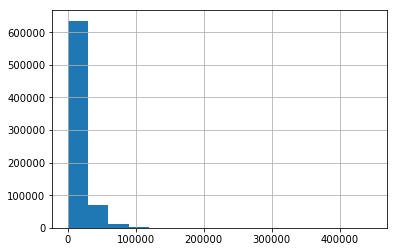

In [91]:
df[df['avg_cur_bal']<463698]['avg_cur_bal'].hist(bins=15)
plt.show()

In [104]:
df[df['avg_cur_bal']<10000].shape

(408615, 60)

In [105]:
# since over 50% of the data is contained when avg_cur_bal < 10000, we fill missing values with median
df['avg_cur_bal'].fillna(df['avg_cur_bal'].median(), inplace=True)

In [112]:
df['bc_open_to_buy'].describe()

count    733034.000000
mean       9436.288340
std       14551.612378
min           0.000000
25%        1304.000000
50%        4240.000000
75%       11299.000000
max      559912.000000
Name: bc_open_to_buy, dtype: float64

In [113]:
# drop bc_open_to_buy because it means "total open-to-buy on revolving bankcards"
# information can be found in (I think) in tot_hi_cred_lim
df.drop('bc_open_to_buy', axis=1, inplace=True)

In [117]:
df['bc_util'].describe()

count    732567.000000
mean         61.644117
std          27.863545
min           0.000000
25%          40.900000
50%          65.500000
75%          86.000000
max         339.600000
Name: bc_util, dtype: float64

In [118]:
# fill with mean (data is not very skewed)
df['bc_util'].fillna(df['bc_util'].mean(), inplace=True)

In [121]:
df['inq_last_6mths'].value_counts()

0.0    427576
1.0    220004
2.0     89382
3.0     36329
4.0     10071
5.0      3577
6.0       900
7.0        48
8.0        22
Name: inq_last_6mths, dtype: int64

In [122]:
# fill with median due to integer values
df['inq_last_6mths'].fillna(df['inq_last_6mths'].median(), inplace=True)

In [127]:
# fill with mode due to categorical values
df['last_credit_pull_d'].fillna(df['last_credit_pull_d'].mode()[0], inplace=True)

In [129]:
df['dti'].describe()

count    787881.000000
mean         17.832820
std           8.845265
min          -1.000000
25%          11.610000
50%          17.320000
75%          23.580000
max         999.000000
Name: dti, dtype: float64

In [132]:
# df.iloc[645411]
df[df['dti']==-1]['dti']

645411   -1.0
Name: dti, dtype: float64

In [134]:
# fill with mean; data is not skewed
# there is only one value of -1, I thought was impossible and placeholder for NaN
# however, maybe it's possible?
df['dti'].fillna(df['dti'].mean(), inplace=True)

In [136]:
# Fill with mode (categorical)
df['last_pymnt_d'].fillna(df['last_pymnt_d'].mode()[0], inplace=True)

In [137]:
df['mort_acc'].describe()

count    740629.000000
mean          1.764267
std           2.087446
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          51.000000
Name: mort_acc, dtype: float64

In [139]:
# fill with median (integer-valued)
df['mort_acc'].fillna(df['mort_acc'].median(), inplace=True)

In [142]:
df[df['num_bc_sats'] != df['num_bc_tl']][['num_bc_sats','num_bc_tl']]

,num_bc_sats,num_bc_tl
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [143]:
# drop num_bc_tl because (I believe) it's more important than num_bc_sats, and has more missing values
df.drop('num_bc_sats', axis=1, inplace=True)

In [158]:
(df['pub_rec_bankruptcies'] == df['pub_rec']).sum()

749273

In [154]:
df['pub_rec_bankruptcies'] = df.apply(lambda row: row['pub_rec'] if np.isnan(row['pub_rec_bankruptcies']) else row['pub_rec_bankruptcies'],axis=1)

In [161]:
df['revol_util'].describe()

count    787436.000000
mean          0.530831
std           0.243244
min           0.000000
25%           0.351000
50%           0.538000
75%           0.719000
max           8.923000
Name: revol_util, dtype: float64

In [162]:
# Fill with mean (not skewed) - could figure this out using other variables later
df['revol_util'].fillna(df['revol_util'].mean(), inplace=True)

In [172]:
# drop because 76% are 0, and the remaining have the same distribution of labels as total sample
df.drop("num_accts_ever_120_pd", axis=1, inplace=True)

In [175]:
df['num_actv_bc_tl'].describe()

count    720383.000000
mean          3.635744
std           2.187278
min           0.000000
25%           2.000000
50%           3.000000
75%           5.000000
max          33.000000
Name: num_actv_bc_tl, dtype: float64

In [176]:
# fill with median (integer-valued)
df['num_actv_bc_tl'].fillna(df['num_actv_bc_tl'].median(), inplace=True)

In [179]:
# fill with median (integer-valued)
df['num_actv_rev_tl'].fillna(df['num_actv_rev_tl'].median(), inplace=True)

In [181]:
# fill with median (integer-valued)
df['num_bc_tl'].fillna(df['num_bc_tl'].median(), inplace=True)

In [189]:
# fill with rounded-down mean
df['num_il_tl'].fillna(np.floor(df['num_il_tl'].median()), inplace=True)

In [198]:
# fill with rounded-down mean
df['num_op_rev_tl'].fillna(np.floor(df['num_op_rev_tl'].mean()), inplace=True)

In [199]:
df['num_rev_accts'].fillna(np.floor(df['num_rev_accts'].mean()), inplace=True)

In [200]:
df['num_rev_tl_bal_gt_0'].fillna(df['num_rev_tl_bal_gt_0'].median(), inplace=True)

In [208]:
df['num_sats'].fillna(df['num_sats'].median(), inplace=True)

In [211]:
df['num_tl_op_past_12m'].fillna(df['num_tl_op_past_12m'].median(), inplace=True)

In [213]:
df['pct_tl_nvr_dlq'].describe()

count    720248.000000
mean         94.398238
std           8.384764
min           0.000000
25%          91.700000
50%          98.100000
75%         100.000000
max         100.000000
Name: pct_tl_nvr_dlq, dtype: float64

In [214]:
df['pct_tl_nvr_dlq'].fillna(df['pct_tl_nvr_dlq'].median(), inplace=True)

In [216]:
df['percent_bc_gt_75'].describe()

count    732760.000000
mean         47.331868
std          35.624645
min           0.000000
25%          16.700000
50%          50.000000
75%          75.000000
max         100.000000
Name: percent_bc_gt_75, dtype: float64

In [218]:
df['percent_bc_gt_75'].fillna(df['percent_bc_gt_75'].median(), inplace=True)

In [220]:
df['tot_coll_amt'].value_counts(normalize=True)[0]

0.8556087525663432

In [221]:
df.drop('tot_coll_amt', axis=1, inplace=True)

In [226]:
# fill with median because of outliers
df['tot_cur_bal'].fillna(df['tot_cur_bal'].median(), inplace=True)

In [231]:
# fill with median because of outliers
df['tot_hi_cred_lim'].fillna(df['tot_hi_cred_lim'].median(), inplace=True)

In [234]:
# fill with median because of outliers
df['total_bal_ex_mort'].fillna(df['total_bal_ex_mort'].median(), inplace=True)

In [237]:
# fill with median because of outliers
df['total_bc_limit'].fillna(df['total_bc_limit'].median(), inplace=True)

In [239]:
# fill with median because of outliers
df['total_il_high_credit_limit'].fillna(df['total_il_high_credit_limit'].median(), inplace=True)

In [241]:
# fill with median because of outliers
df['total_rev_hi_lim'].fillna(df['total_rev_hi_lim'].median(), inplace=True)

In [242]:
df.isnull().sum()

acc_open_past_24mths          0
addr_state                    0
annual_inc                    0
avg_cur_bal                   0
bc_util                       0
collection_recovery_fee       0
delinq_2yrs                   0
dti                           0
earliest_cr_line              0
emp_length                    0
funded_amnt                   0
funded_amnt_inv               0
grade                         0
home_ownership                0
initial_list_status           0
inq_last_6mths                0
installment                   0
int_rate                      0
issue_d                       0
last_credit_pull_d            0
last_pymnt_amnt               0
last_pymnt_d                  0
loan_amnt                     0
loan_status                   0
mort_acc                      0
num_actv_bc_tl                0
num_actv_rev_tl               0
num_bc_tl                     0
num_il_tl                     0
num_op_rev_tl                 0
num_rev_accts                 0
num_rev_

In [243]:
len(df.columns)

56

In [245]:
df.to_csv("cleaned_data.csv", index=False)